### Train NNs on the toy example

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
import dama as dm
import pickle
import os

from freedom.toy_model import toy_model
from types import SimpleNamespace
from toy_NN_trafo import build_q_trafo, build_h_trafo

%load_ext autoreload
%autoreload 2

2022-01-24 11:57:24.812540: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
toy_experiment = toy_model.toy_experiment(detector_xs = np.linspace(-5, 5, 5), t_std=1)

In [4]:
example_x_src = 1.45
example_b_src = 1.1
example_N_src = 3.5

In [5]:
# generate one test event
test_event = toy_experiment.generate_event(x_src=example_x_src, b=example_b_src, N_src=example_N_src)

In [6]:
%%time
# Grid scan

g = dm.GridData(x=np.linspace(-5, 5, 100), b=np.linspace(-2, 2, 100))

g['dom_hit_term'] = np.empty(g.shape)
g['dom_charge_terms'] = np.empty(g.shape)
g['total_charge_hit_terms'] = np.empty(g.shape)
g['total_charge_terms'] = np.empty(g.shape)

for idx in np.ndindex(g.shape):
    hypo_x =  g['x'][idx]
    hypo_b =  g['b'][idx]
    hypo_t = 0
    hypo_N_src = example_N_src
    g['dom_hit_term'][idx] = -toy_experiment.dom_hit_term(test_event[1], hypo_x, hypo_b, 0)
    g['dom_charge_terms'][idx] = -toy_experiment.dom_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)
    g['total_charge_hit_terms'][idx] = -toy_experiment.total_charge_hit_term(test_event[1], hypo_x, hypo_b, hypo_t, hypo_N_src)
    g['total_charge_terms'][idx] = -toy_experiment.total_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)

CPU times: user 8.84 s, sys: 4 ms, total: 8.84 s
Wall time: 8.84 s


In [7]:
g['dom_hit_term'] -= g['dom_hit_term'].min()
g['dom_charge_terms'] -= g['dom_charge_terms'].min()
g['dom_llh'] = g['dom_hit_term'] + g['dom_charge_terms']
g['total_charge_hit_terms'] -= g['total_charge_hit_terms'].min()
g['total_charge_terms'] -= g['total_charge_terms'].min()
g['total_charge_llh'] = g['total_charge_hit_terms'] + g['total_charge_terms']

In [8]:
def plot_diff(a, b, axes, title_a='a', title_b='b', vmax=None, limit_diff=False, **kwargs):
    a.plot(ax=axes[0], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    axes[0].set_title(title_a)
    b.plot(ax=axes[1], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    axes[1].set_title(title_b)
    diff = a - b
    if limit_diff:
        diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-vmax, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    else:
        diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta LLH$', **kwargs) 
    axes[2].set_title('diff')

In [9]:
def plot_truth(axes, x, y):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax in axes.flatten():
        ax.plot([x], [y], marker='$T$', markersize=10, color='white')

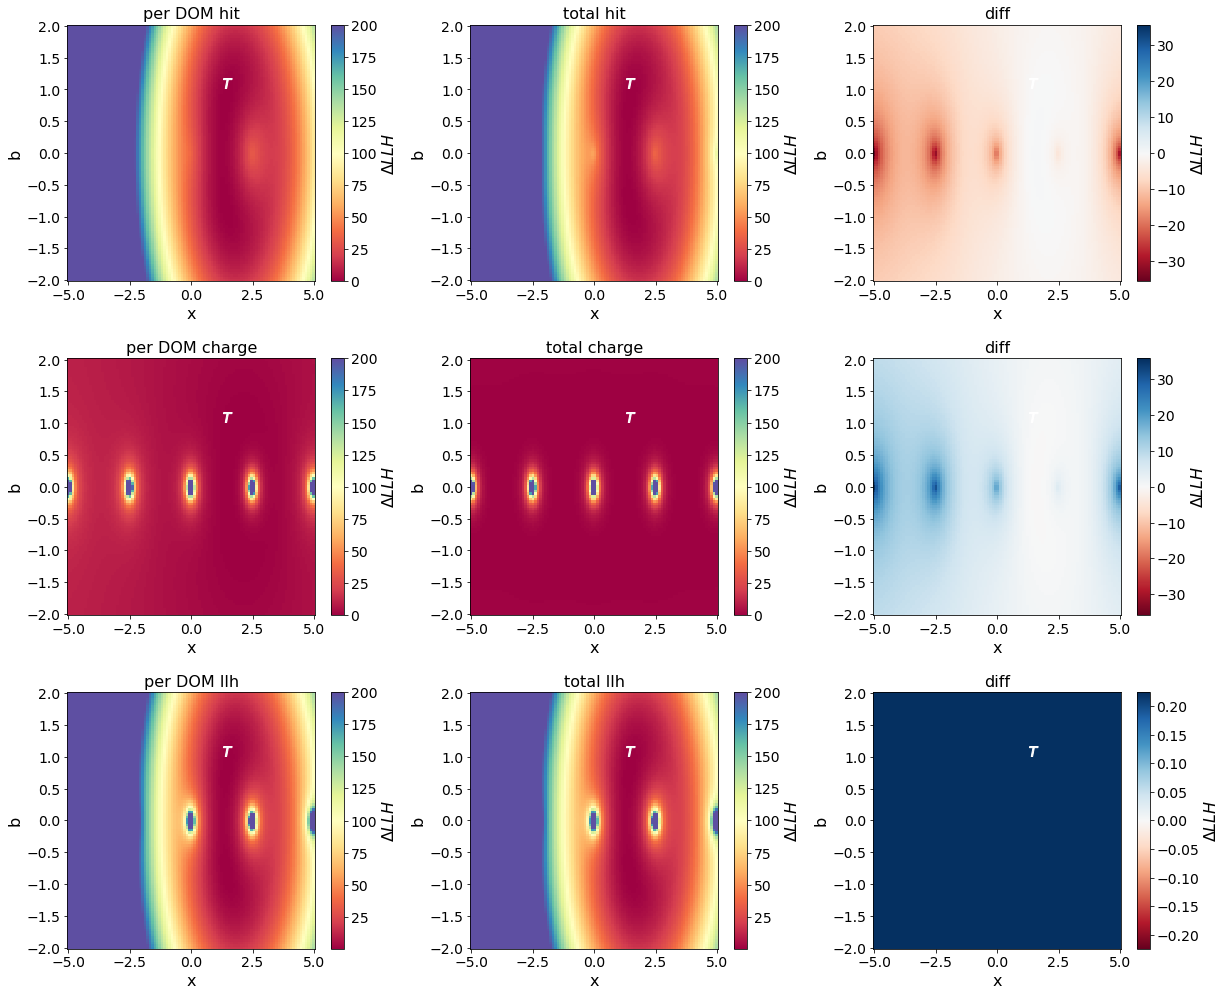

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20,17))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plot_diff(g['dom_hit_term'], g['total_charge_hit_terms'], axes=ax[0], title_a='per DOM hit', title_b='total hit', vmax=200)
plot_diff(g['dom_charge_terms'], g['total_charge_terms'], axes=ax[1], title_a='per DOM charge', title_b='total charge', vmax=200)
plot_diff(g['dom_llh'], g['total_charge_llh'], axes=ax[2], title_a='per DOM llh', title_b='total llh', vmax=200)

plot_truth(ax, example_x_src, example_b_src)

# Train NNs

In [11]:
#!rm events.pkl

In [12]:
%%time
fname = 'toy_mc_sim_events_more_evts_paper.pkl'
if os.path.isfile(fname):
    with open(fname, 'rb') as file:
        events = pickle.load(file)
else:
    events = toy_experiment.generate_events(int(1e5), N_lims=(0, 20))
    with open(fname, 'wb') as file:
        pickle.dump(events, file, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 440 ms, sys: 112 ms, total: 552 ms
Wall time: 554 ms


In [13]:
mc, truth = events

In [14]:
hitnet = SimpleNamespace()
chargenet = SimpleNamespace()

Prepare Data for NN

In [15]:
mc[0][0]

array([[ 5. , -5. ,  0. ],
       [ 3. , -2.5,  1. ],
       [ 1. ,  0. ,  2. ],
       [ 1. ,  2.5,  3. ],
       [ 0. ,  5. ,  4. ]])

In [16]:
chargenet.x = []
hitnet.x = []
for item in mc:
    chargenet.x.append(item[1].shape[0])
    hitnet.x.append(item[1])

In [17]:
chargenet.x = np.array(chargenet.x)[:, np.newaxis]
hitnet.x = np.concatenate(hitnet.x)

In [18]:
chargenet.t = np.copy(truth)
hitnet.t = np.repeat(truth, chargenet.x[:, 0], axis=0)

In [19]:
assert chargenet.x.shape[0] == chargenet.t.shape[0]
assert hitnet.x.shape[0] == hitnet.t.shape[0]

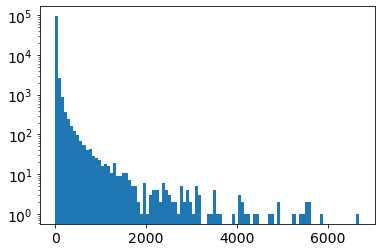

In [20]:
plt.hist(chargenet.x[:,0], bins=100)
plt.gca().set_yscale('log')

In [21]:
def get_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12, test=False):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        test : bool
            no shuffling, prefetching and caching
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        if not test:
            dataset = dataset.shuffle(shuffle_block_size)

        return dataset.batch(batch_size)

## chargenet

In [22]:
chargenet.x_train, chargenet.x_test, chargenet.t_train, chargenet.t_test = train_test_split(chargenet.x, chargenet.t, test_size=0.2, random_state=42)

In [23]:
chargenet.d_train = get_dataset(chargenet.x_train, chargenet.t_train)
chargenet.d_test = get_dataset(chargenet.x_test, chargenet.t_test, test=True)

2022-01-24 11:57:41.975315: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-24 11:57:41.977764: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-24 11:57:41.999858: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-24 11:57:41.999926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: schwyz
2022-01-24 11:57:41.999944: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: schwyz
2022-01-24 11:57:42.000103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.56.0
2022-01-24 11:57:42.000172: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.56.0
2022-01-24 11:57:42.000187: I tensorflow/stream_executor/cuda/cud

In [24]:
det_xs = toy_experiment.detector_xs

chargenet.trafo = build_q_trafo(det_xs)

In [25]:
activation='relu'

x_input = tf.keras.Input(shape=(chargenet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(chargenet.t_train.shape[1],))

h = chargenet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

# h = tf.keras.layers.Dense(32, activation=activation)(h)

# h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

chargenet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
chargenet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
q_trafo (q_trafo)               (None, 5)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         q_trafo[0][0]                

In [26]:
optimizer = tf.keras.optimizers.Adam(0.0005)
chargenet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [27]:
chargenet.hist = chargenet.model.fit(chargenet.d_train, epochs=30, verbose=1, validation_data=chargenet.d_test)

Epoch 1/30


2022-01-24 11:57:43.584518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-24 11:57:43.588117: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394785000 Hz


40/40 [==============================] - 4s 64ms/step - loss: 0.8783 - val_loss: 0.6869
Epoch 2/30
40/40 [==============================] - 2s 45ms/step - loss: 0.6692 - val_loss: 0.6155
Epoch 3/30
40/40 [==============================] - 2s 44ms/step - loss: 0.6237 - val_loss: 0.5874
Epoch 4/30
40/40 [==============================] - 2s 46ms/step - loss: 0.5877 - val_loss: 0.5608
Epoch 5/30
40/40 [==============================] - 2s 43ms/step - loss: 0.5643 - val_loss: 0.5379
Epoch 6/30
40/40 [==============================] - 2s 49ms/step - loss: 0.5426 - val_loss: 0.5212
Epoch 7/30
40/40 [==============================] - 2s 54ms/step - loss: 0.5192 - val_loss: 0.4979
Epoch 8/30
40/40 [==============================] - 2s 55ms/step - loss: 0.4942 - val_loss: 0.4841
Epoch 9/30
40/40 [==============================] - 2s 47ms/step - loss: 0.4779 - val_loss: 0.4631
Epoch 10/30
40/40 [==============================] - 2s 53ms/step - loss: 0.4646 - val_loss: 0.4516
Epoch 11/30
40/40 [=

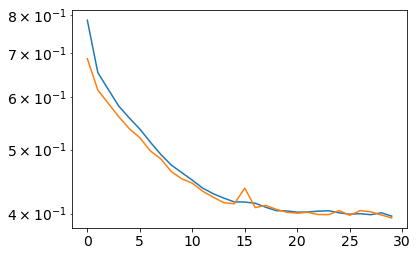

In [28]:
plt.plot(chargenet.model.history.history['loss'])
plt.plot(chargenet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [29]:
chargenet.llh = tf.keras.models.clone_model(chargenet.model)
chargenet.llh.set_weights(chargenet.model.get_weights())
chargenet.llh.layers[-1].activation = tf.keras.activations.linear
chargenet.llh.compile()

In [30]:
chargenet.tts = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T

chargenet.xxs = np.repeat(len(test_event[0]), np.prod(g.shape), axis=0)
chargenet.xxs = chargenet.xxs.reshape(-1, 1)

In [31]:
chargenet.llhs = chargenet.llh.predict([chargenet.xxs, chargenet.tts])    

In [32]:
g['charge_llh'] = -np.sum(chargenet.llhs.reshape(-1, 1), axis=1).reshape(g.shape)
g['charge_llh'] -= np.min(g['charge_llh'])

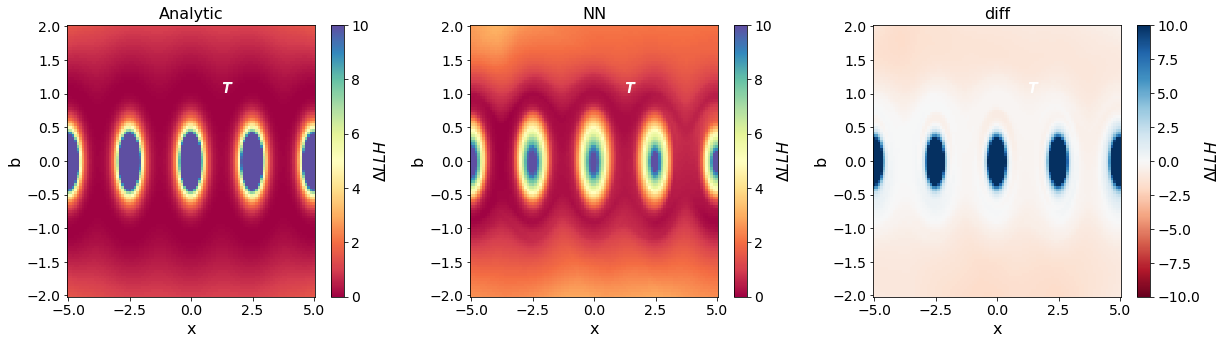

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['total_charge_terms'], g['charge_llh'], title_a='Analytic', title_b='NN', vmax=10, axes=ax, limit_diff=True)
plot_truth(ax, example_x_src, example_b_src)

## hitnet

In [34]:
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.x, hitnet.t, test_size=0.2, random_state=42)

In [35]:
hitnet.d_train = get_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = get_dataset(hitnet.x_test, hitnet.t_test, test=True)

In [36]:
hitnet.trafo = build_h_trafo(det_xs)

In [37]:
activation='elu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
h_trafo (h_trafo)               (None, 8)            0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 32)           288         h_trafo[0][0]              

In [38]:
optimizer = tf.keras.optimizers.Adam(0.0005)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [39]:
hist = hitnet.model.fit(hitnet.d_train, epochs=10, verbose=1, validation_data=hitnet.d_test)

Epoch 1/10
1013/1013 [==============================] - 53s 51ms/step - loss: 0.2741 - val_loss: 0.2343
Epoch 2/10
1013/1013 [==============================] - 52s 51ms/step - loss: 0.2315 - val_loss: 0.2282
Epoch 3/10
1013/1013 [==============================] - 54s 53ms/step - loss: 0.2283 - val_loss: 0.2262
Epoch 4/10
1013/1013 [==============================] - 54s 53ms/step - loss: 0.2270 - val_loss: 0.2266
Epoch 5/10
1013/1013 [==============================] - 54s 53ms/step - loss: 0.2262 - val_loss: 0.2263
Epoch 6/10
1013/1013 [==============================] - 53s 52ms/step - loss: 0.2247 - val_loss: 0.2252
Epoch 7/10
1013/1013 [==============================] - 53s 52ms/step - loss: 0.2246 - val_loss: 0.2250
Epoch 8/10
1013/1013 [==============================] - 55s 54ms/step - loss: 0.2242 - val_loss: 0.2239
Epoch 9/10
1013/1013 [==============================] - 57s 56ms/step - loss: 0.2233 - val_loss: 0.2232
Epoch 10/10
1013/1013 [==============================] - 56s 55m

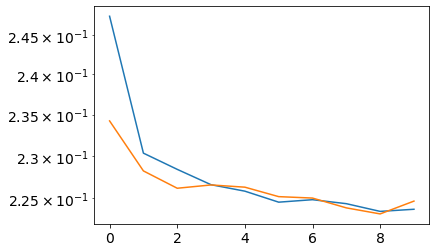

In [40]:
plt.plot(hitnet.model.history.history['loss'])
plt.plot(hitnet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [41]:
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [42]:
hitnet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
hitnet.tts = np.repeat(hitnet.tt, test_event[1].shape[0], axis=0)
hitnet.xxs = np.repeat(test_event[1][np.newaxis,:, :], np.prod(g.shape), axis=0)
hitnet.xxs = hitnet.xxs.reshape(-1, 3)

In [43]:
hitnet.llhs = hitnet.llh.predict([hitnet.xxs, hitnet.tts])    

In [44]:
g['hit_llh'] = -np.sum(hitnet.llhs.reshape(-1, test_event[1].shape[0]), axis=1).reshape(g.shape)
g['hit_llh'] -= np.min(g['hit_llh'])

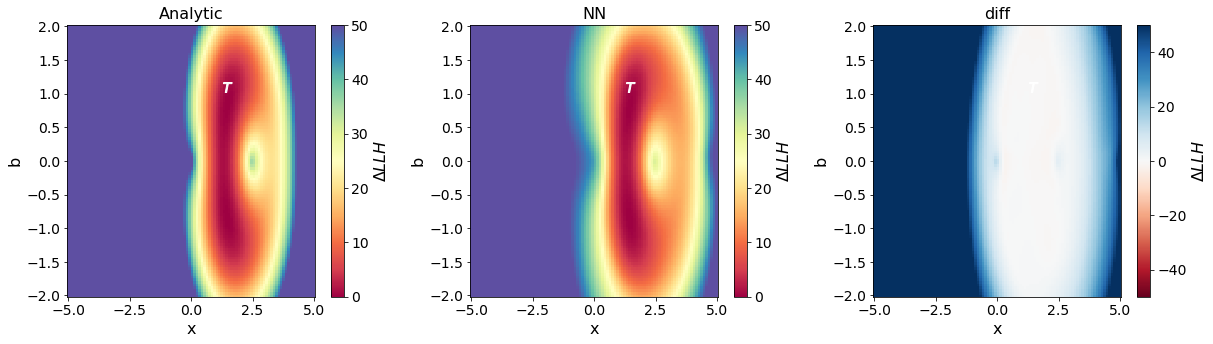

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['total_charge_hit_terms'], g['hit_llh'], title_a='Analytic', title_b='NN', 
          vmax=50, axes=ax, limit_diff=True)
plot_truth(ax, example_x_src, example_b_src)

In [46]:
g['llh'] = g['charge_llh'] + g['hit_llh']
g['llh'] -= np.min(g['llh'])

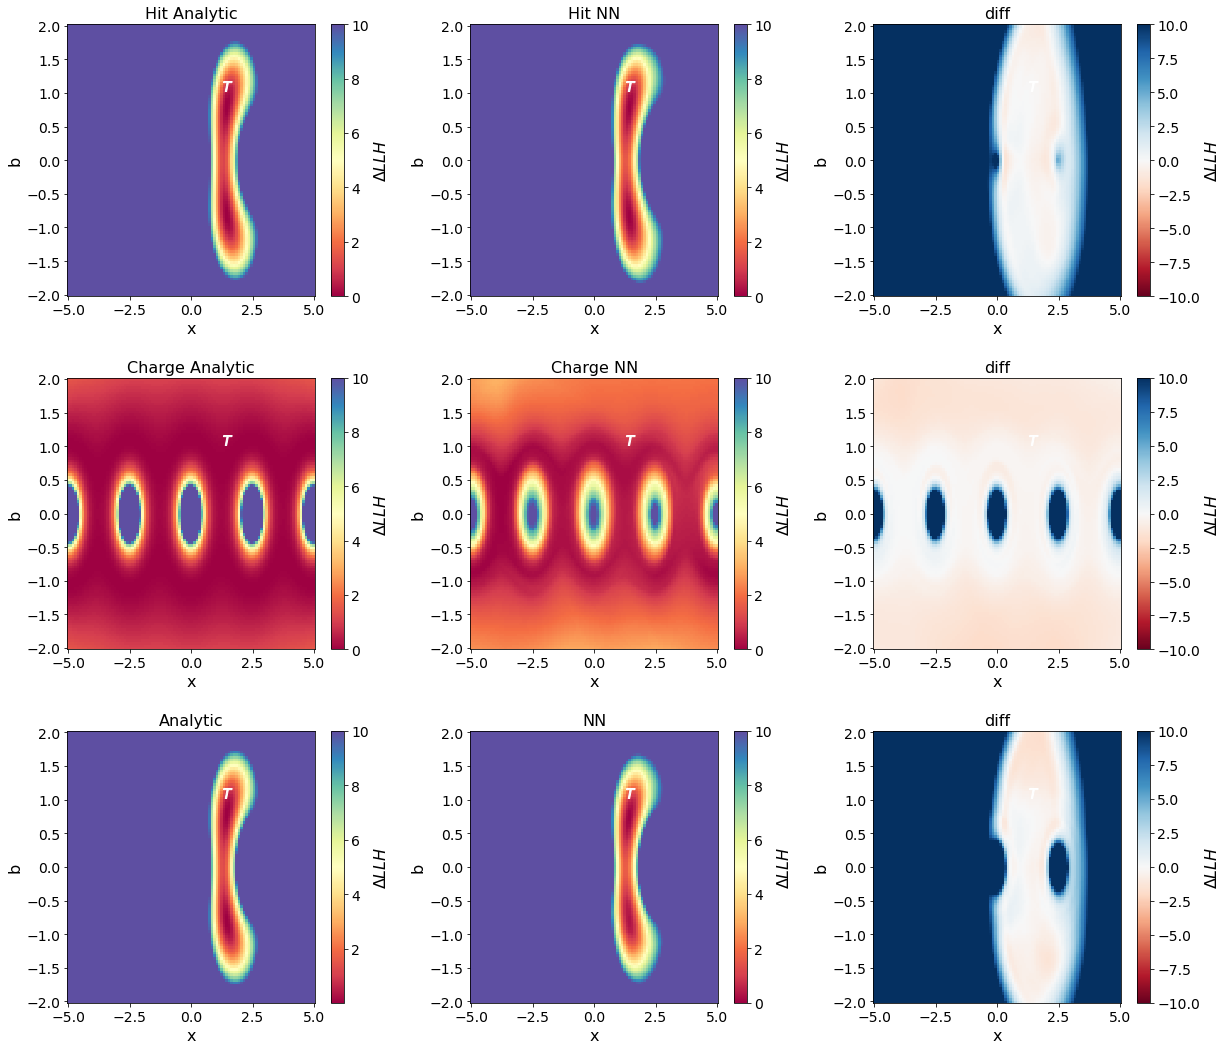

In [47]:
fig, ax = plt.subplots(3, 3, figsize=(20,18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Zoom in
#grid_to_plot = g[example_x_src-0.5:example_x_src+0.5, example_b_src-0.5:example_b_src+0.5]

grid_to_plot = g

plot_diff(grid_to_plot['total_charge_hit_terms'], grid_to_plot['hit_llh'], 
          title_a='Hit Analytic', title_b='Hit NN', vmax=10, axes=ax[0], limit_diff=True)
plot_diff(grid_to_plot['total_charge_terms'], grid_to_plot['charge_llh'], 
          title_a='Charge Analytic', title_b='Charge NN', vmax=10, axes=ax[1], limit_diff=True)
plot_diff(grid_to_plot['total_charge_llh'], grid_to_plot['llh'], title_a='Analytic',
          title_b='NN', vmax=10, axes=ax[2], limit_diff=True)

plot_truth(ax, example_x_src, example_b_src)

#plt.savefig('NNtest.png', bbox_inches='tight')

### Save the models now

In [48]:
chargenet.model.save('paper_toy_chargenet.h5')

In [49]:
hitnet.model.save('paper_toy_hitnet.h5')